In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from utils import *
from siamese import *

device = "cuda" if torch.cuda.is_available() else "cpu"

## Train and Inference loop

#### Hyperparameter dict

In [3]:
lr_dict = {
    "bottle": 7e-4,
    "cable": 7e-4,
    "capsule": 1e-4,
    "carpet": 7e-4,
    "grid": 3e-3,
    "hazelnut": 1e-4,
    "leather": 5e-4,
    "metal_nut": 7e-4,
    "pill": 1e-3,  # normal lr: 7e-4
    "screw": 3e-4,
    "tile": 3e-4,
    "toothbrush": 7e-4,
    "transistor": 5e-4,
    "wood": 7e-4,
    "zipper": 1e-4,
}

epochs_dict = {
    "bottle": [200],
    "cable": [400],
    "capsule": [400],
    "carpet": [200],
    "grid": [600],
    "hazelnut": [200],
    "leather": [200],
    "metal_nut": [200],
    "pill": [400],
    "screw": [300],
    "tile": [200],
    "toothbrush": [400],
    "transistor": [200],
    "wood": [400],
    "zipper": [200],
}

step_size_dict = {
    "bottle": 30,
    "cable": 20,
    "capsule": 80,
    "carpet": 20,
    "grid": 60,
    "hazelnut": 20,
    "leather": 20,
    "metal_nut": 10,
    "pill": 50,
    "screw": 50,
    "tile": 25,
    "toothbrush": 25,
    "transistor": 20,
    "wood": 40,
    "zipper": 20,
}

#### Training-Inference pipeline

Using cuda
----------------------------------------------------------------
bottle

----------------------------------------------------------------
cable

----------------------------------------------------------------
capsule

resnet50

Start new training


100%|██████████| 400/400 [1:37:54<00:00, 14.69s/it]
/media/khoa-ys/Personal/Materials/Master's Thesis/image_similarity_assessment/src/siamese.py:314: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


----------------------------------------------------------------
carpet

----------------------------------------------------------------
grid

resnet50

Start new training


100%|██████████| 600/600 [1:59:51<00:00, 11.99s/it]  


----------------------------------------------------------------
hazelnut

----------------------------------------------------------------
leather

----------------------------------------------------------------
metal_nut

resnet50

Start new training


100%|██████████| 200/200 [34:59<00:00, 10.50s/it]


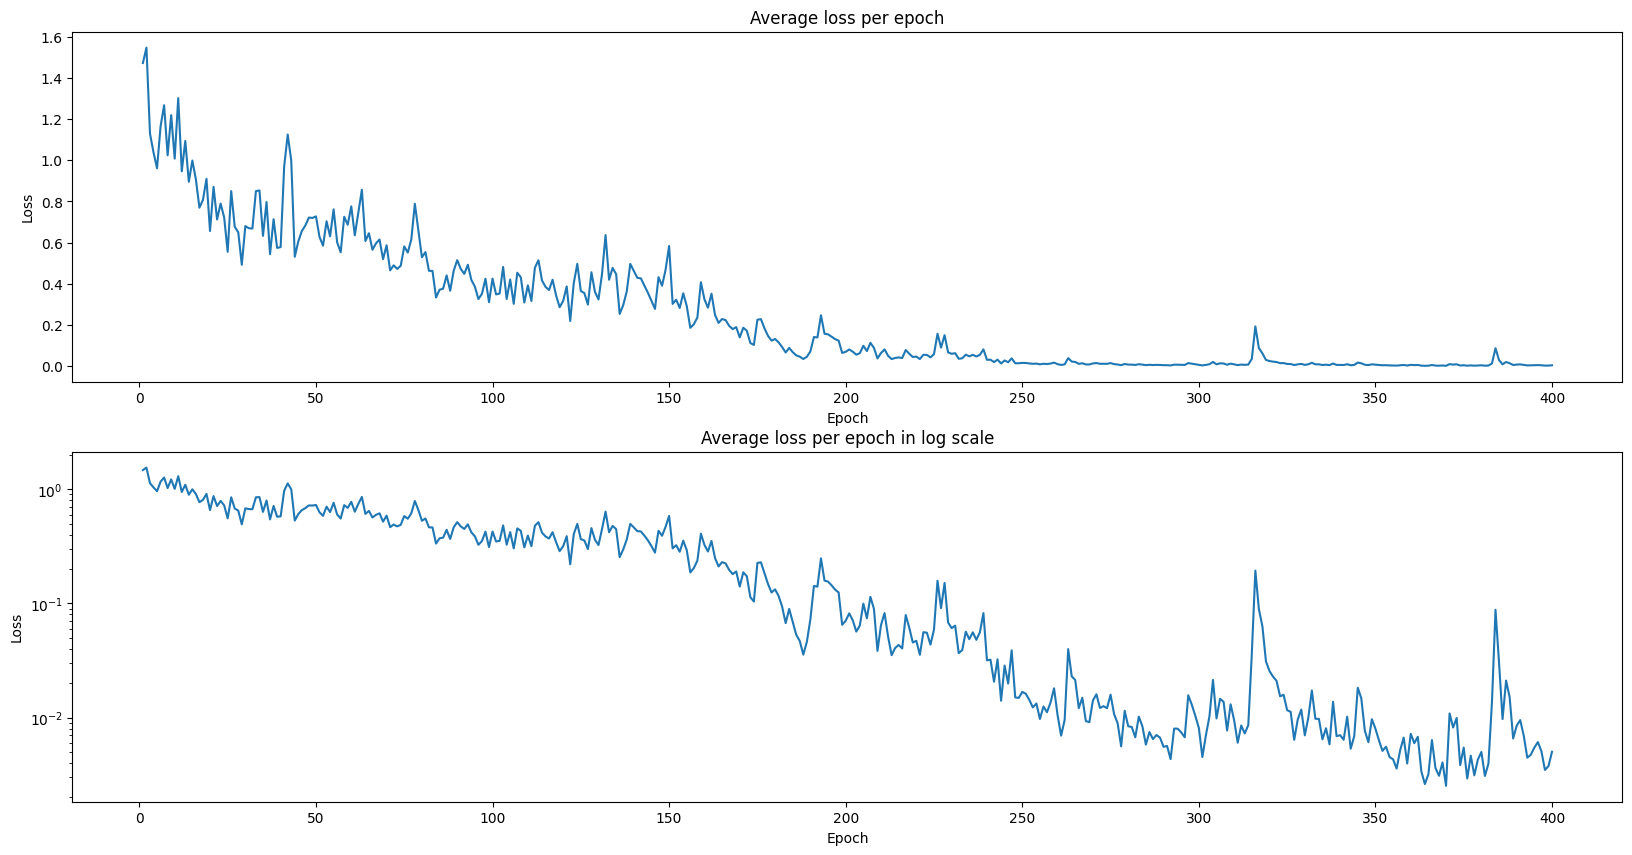

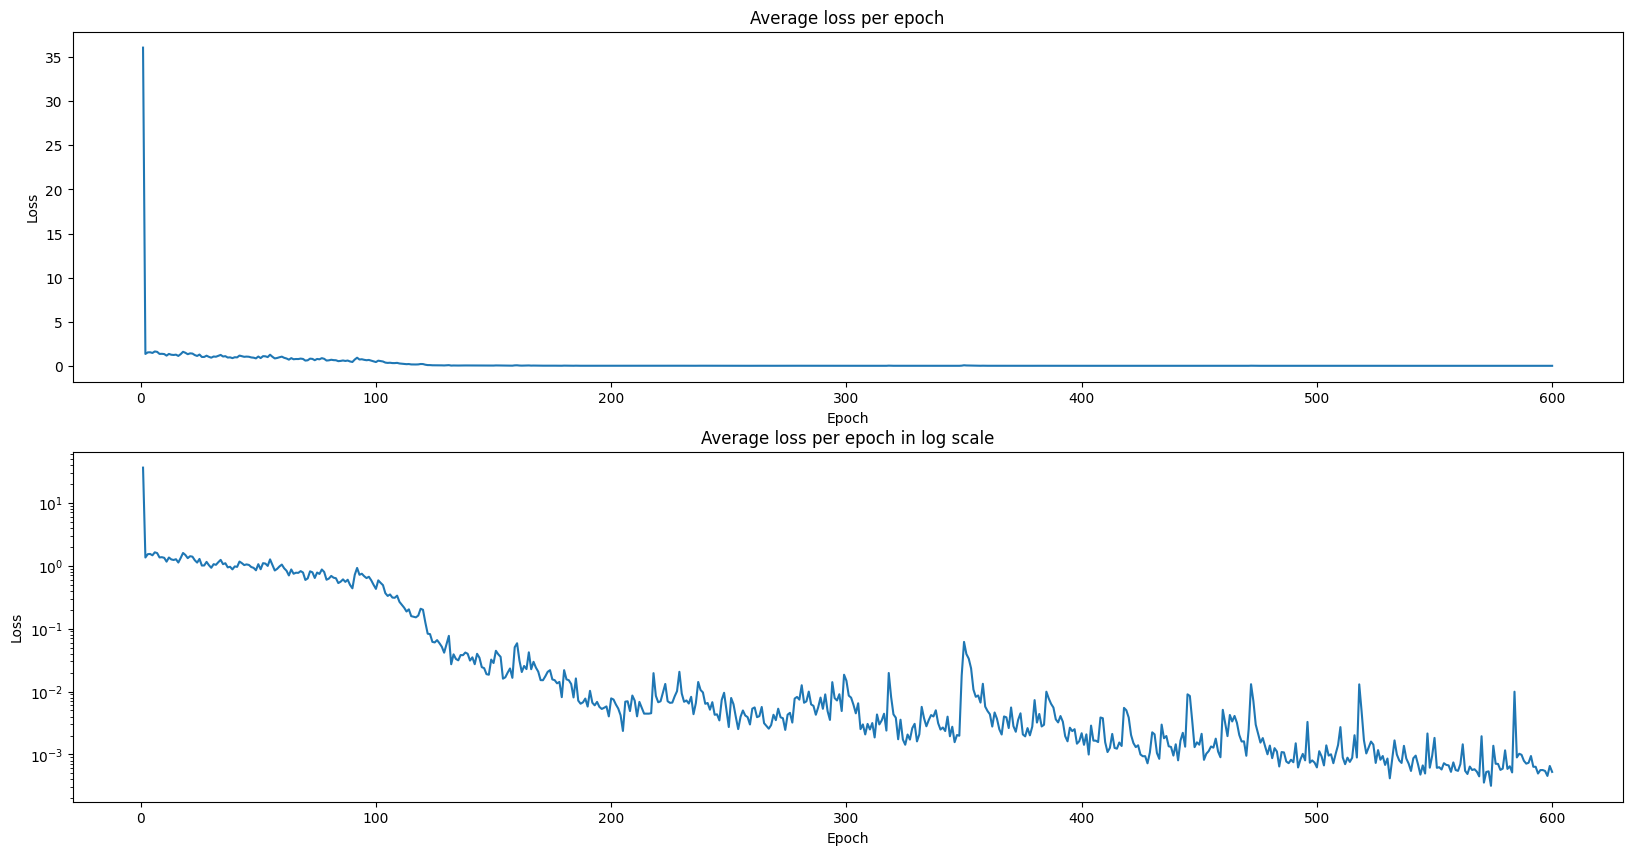

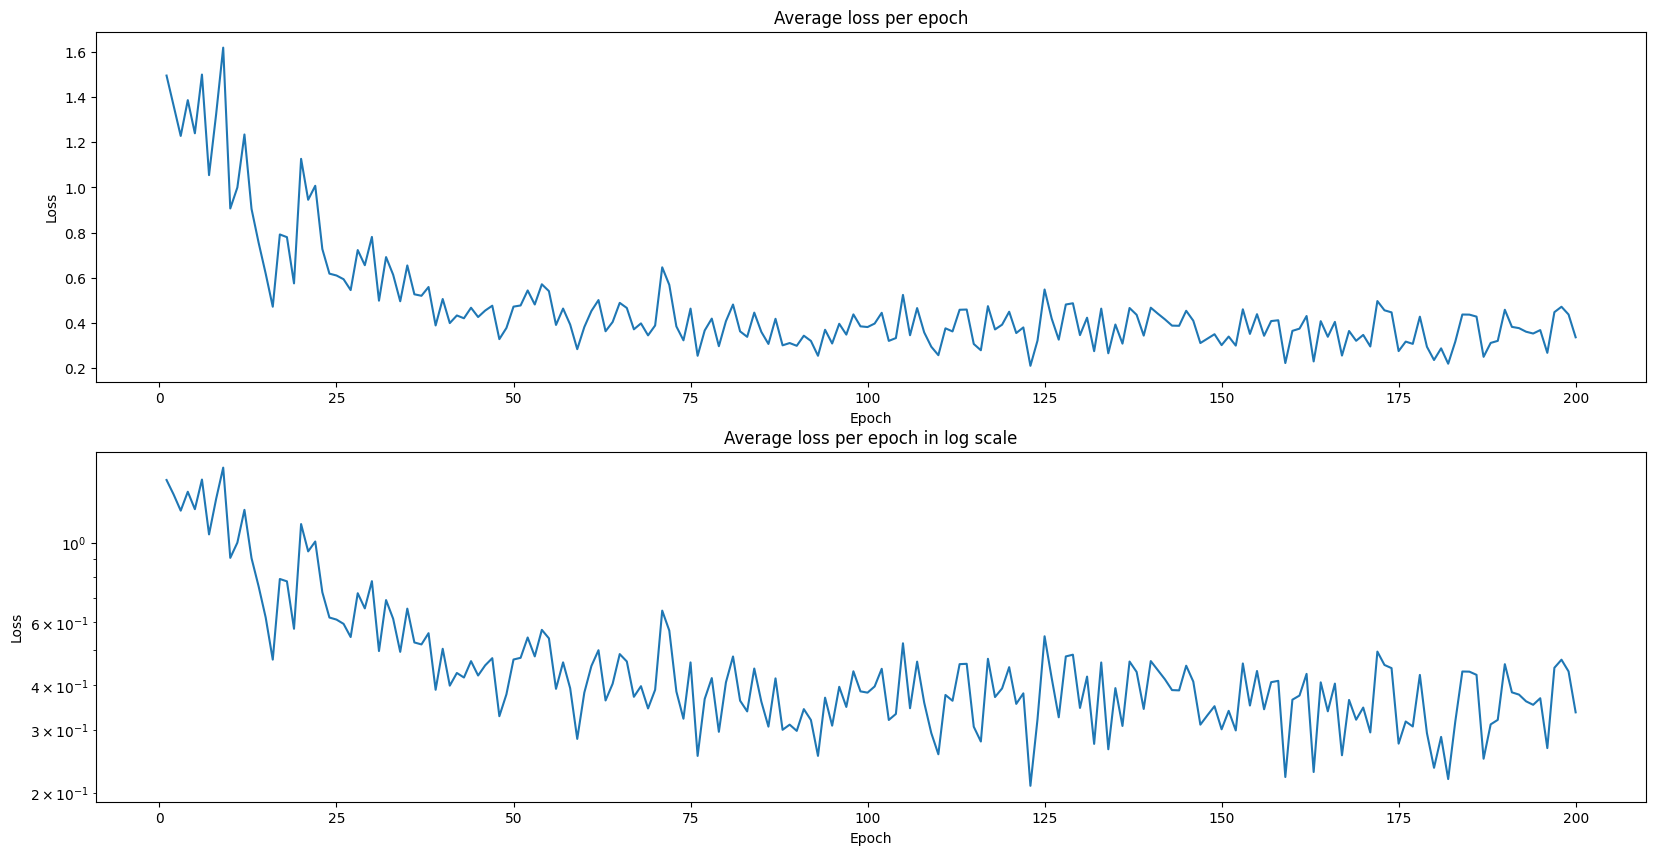

In [4]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/multi_classed_grouped_data")
products = os.listdir(data_path)
train = True
visualize = True
# products = ['bottle', 'hazelnut', 'metal_nut', 'toothbrush', 'transistor', 'leather', 'cable',  'zipper', 'wood']
print(f"Using {device}")

for product in products[:8]:
    print("----------------------------------------------------------------")

    print(product + "\n")
    if product in ["bottle"]:
        backbone_list = ["resnet18", "resnet34", "wide_resnet", "vgg"][4:]
    elif product in ["cable"]:
        backbone_list = ["resnet18", "resnet34", "wide_resnet"][3:]
    elif product in [
        "transistor",
        "metal_nut",
        "zipper",
        "pill",
        "grid",
        "screw",
        "capsule",
    ]:
        backbone_list = ["resnet18", "resnet34", "resnet50"][2:]
    else:
        backbone_list = ["resnet18", "resnet34"][2:]

    for backbone in backbone_list:
        print(backbone + "\n")
        # if backbone == 'resnet18' and product in products[:-6]:
        #     continue
        torch.cuda.empty_cache()
        # Load data to dict
        product_path = os.path.join(data_path, product)

        # Load data dicts
        json_path = os.path.join(root_path, "data/augmented_train_test_split", product)
        train_dict = json.load(
            open(os.path.join(json_path, product + "_train_dict.json"), "r")
        )
        test_dict = json.load(
            open(os.path.join(json_path, product + "_test_dict.json"), "r")
        )

        # Hyperparameters
        n_classes = len(np.unique(list(train_dict.values())))
        model = SiameseNetwork(backbone=backbone)
        learning_rate = lr_dict[product]
        step_size = step_size_dict[product]
        epochs = epochs_dict[product][0]
        if backbone in ["resnet18"]:
            batch_size = 32
        if backbone in ["resnet34"]:
            batch_size = 16
        elif backbone in ["resnet50", "vgg"]:
            batch_size = 8
        elif backbone in ["wide_resnet"]:
            batch_size = 2

        # Dataloaders:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((512, 512), antialias=True),
                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )

        train_dataset = ProductDataset(image_label_dict=train_dict, transform=transform)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

        # Visualize dataset
        example_batch = next(iter(train_dataloader))

        # Training
        model_name = product + "_siamese_" + backbone + "_subclass_sampling.pth"
        train_model_path = os.path.join(root_path, "models/" + model_name)
        if train:
            figure_name = model_name[:-4] + "_training_loss.png"
            train_figure_path = os.path.join(
                root_path, "Figure/training_loss/" + figure_name
            )
            if len(epochs_dict[product]) > 1 and backbone == "resnet18":
                print("Resume Training")
                resume_epoch = epochs_dict[product][1]
                resume_model_path = os.path.join(
                    root_path,
                    "models",
                    model_name[:-4] + "_" + str(resume_epoch) + ".pth",
                )
                learning_rate = learning_rate * (0.5 ** (resume_epoch / step_size))
                model_train(
                    model,
                    train_dataloader,
                    (epochs_dict[product][0] - epochs_dict[product][1]),
                    learning_rate,
                    batch_size,
                    step_size,
                    device,
                    visualize,
                    train_figure_path,
                    True,
                    train_model_path,
                    True,
                    resume_model_path,
                )
            else:
                print("Start new training")
                model_train(
                    model,
                    train_dataloader,
                    epochs,
                    learning_rate,
                    batch_size,
                    step_size,
                    device,
                    visualize,
                    train_figure_path,
                    True,
                    train_model_path,
                )
        torch.cuda.empty_cache()